**Función:** crear un sub dataset 10k limpio con fotos en gris

**Requiere:**
- ../datasets/df_clean.json

**Crea:**
- ../datasets/X_train_gris.pkl
- ../datasets/X_test_gris.pkl
- ../datasets/y_train_gris.pkl
- ../datasets/y_test_gris.pkl

In [ ]:
ejecutadoEnGoogleDrive = False # True si se ejecuta en Google Drive

In [ ]:
if ejecutadoEnGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/clasificacion_imagenes'
else:
    PATH = '../'

In [1]:
import pandas as pd
import pickle
import numpy as np
import math
import torchvision.transforms as T
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import trange, tqdm
from PIL import Image

In [4]:
photo_path = PATH + 'datasets/photos'
img_size = 224

# Create Train Test DFs. 

In [6]:
df = pd.read_json(PATH + 'datasets/df_clean.json').rename(columns={'reclass_label':'label'})

In [7]:
df.head(2)

,photo_id,label
0,fB-J1F60DgMRoc8eI0z0Ew,food
1,n2hdfzYgxL0twgfSDbro1w,food


In [8]:
df.label.value_counts()

food       4786
inside     2150
drink       677
outside     611
menu         88
Name: label, dtype: int64

In [9]:
round(df.label.value_counts() * 0.8, 0)

food       3829.0
inside     1720.0
drink       542.0
outside     489.0
menu         70.0
Name: label, dtype: float64

In [10]:
def create_df(num_samples, dataframe):
    labels = list(df.label.value_counts().reset_index()['index'])
    proportion = list(df.label.value_counts() / df.shape[0])
    
    dict_samples = {}
    
    for (i, j) in zip(labels, proportion):
        dict_samples[i] = int(round(j * num_samples, 0))

    df_short = pd.DataFrame()

    for i in dict_samples.keys():
        df_temp = dataframe[dataframe['label'] == i].sample(dict_samples[i])
        df_short = pd.concat([df_short, df_temp], axis=0)

    return df_short

In [11]:
train_num = round(df.shape[0] * 0.8, 0)
df_train = create_df(train_num, df)

In [12]:
df_train.reset_index(drop=True, inplace=True)
df_train.tail()

,photo_id,label
6645,q4kIwHDbNgqEe9yLQ8YNGQ,menu
6646,hMd-LMsQ_idkDi5RET8xKw,menu
6647,mXC-AquWd3BQWo4geS4GUg,menu
6648,XQQfi-QX4epfaYePJKH4VQ,menu
6649,g5BQy2a9YHSW-j5LAnq3mw,menu


In [13]:
compared = df.merge(df_train.drop_duplicates(), on='photo_id', how='left', indicator=True)
compared.head(2)

,photo_id,label_x,label_y,_merge
0,fB-J1F60DgMRoc8eI0z0Ew,food,NaN,left_only
1,n2hdfzYgxL0twgfSDbro1w,food,food,both


In [14]:
df_test = compared.loc[compared._merge == 'left_only'].drop(columns=['_merge', 'label_y']).rename(columns={'label_x':'label'})
df_test.head(2)

,photo_id,label
0,fB-J1F60DgMRoc8eI0z0Ew,food
4,z-ftfswcyAAERjoMzKFJ5A,food


In [15]:
print(f'El tamaño de Train es de {df_train.shape[0]} y el de Test es de {df_test.shape[0]}')

El tamaño de Train es de 6650 y el de Test es de 1662


# Reescalar y convertir a 1 canal

In [16]:
def resize_pictures(dataframe, img_path, size_rescaled):
    df_temp = dataframe.copy()
    df_temp['image'] = ''
    
    for im_pos in tqdm(range(len(df_temp)), desc='Photos cropped', miniters=len(df_temp)//100):
        
        with Image.open('{}/{}.jpg'.format(img_path, df_temp.iloc[im_pos].photo_id)) as image:

            width = image.size[0]
            height = image.size[1]

            # redimensionar
            if (height < width): # imagen estrecha
                height = int(size_rescaled)
                height = math.floor(size_rescaled * width/height)
            else: # imagen ancha
                width = math.floor(size_rescaled * height/width)
                height = int(size_rescaled)

            resized = T.Resize((height, width))(image)
            cropped = T.CenterCrop(size=int(size_rescaled))(resized)
            gray = T.Grayscale(num_output_channels=1)(cropped)
            df_temp.iloc[im_pos, 2] = gray

    return df_temp

In [17]:
# Create new train DF
df2_train = resize_pictures(df_train, photo_path, img_size)

# Create new Test DF
df2_test = resize_pictures(df_test, photo_path, img_size)

Photos cropped:   0%|          | 0/6650 [00:00<?, ?it/s]

Photos cropped:   0%|          | 0/1662 [00:00<?, ?it/s]

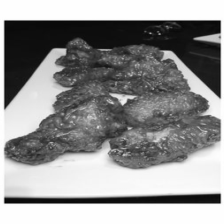

In [18]:
df2_train.iloc[0,2]

In [19]:
np.array(df2_train.iloc[1, 2]).shape

(224, 224)

In [20]:
display(df2_train.head(2))
display(df2_test.head(2))

,photo_id,label,image
0,E5cQW3LYmsATAMzIj2rlZg,food,<PIL.Image.Image image mode=L size=224x224 at ...
1,d4MI3nEv2AyeO2PeLruIdw,food,<PIL.Image.Image image mode=L size=224x224 at ...


,photo_id,label,image
0,fB-J1F60DgMRoc8eI0z0Ew,food,<PIL.Image.Image image mode=L size=224x224 at ...
4,z-ftfswcyAAERjoMzKFJ5A,food,<PIL.Image.Image image mode=L size=224x224 at ...


In [21]:
np.array(df2_train.iloc[1, 2].getdata())

array([115, 114, 113, ...,  63,  67,  67])

In [27]:
series_X_train = df2_train.image.map(lambda img: np.array(img.getdata()).reshape(img_size, img_size))
X_train = np.stack(series_X_train.to_numpy(copy=True))
X_train.shape

(6650, 224, 224)

In [28]:
X_train = X_train.astype('float32')
X_train /= 255

In [29]:
series_X_test = df2_test.image.map(lambda img: np.array(img.getdata()).reshape(img_size, img_size))
X_test = np.stack(series_X_test.to_numpy(copy=True))
X_test.shape

(1662, 224, 224)

In [30]:
X_test = X_test.astype('float32')
X_test /= 255

In [38]:
categories = [['food', 'inside', 'outside', 'drink', 'menu']]
enc = OneHotEncoder(categories=categories, drop=None)

In [39]:
y_train = enc.fit_transform(df_train[['label']]).astype('float32').toarray()

In [40]:
y_test = enc.fit_transform(df_test[['label']]).astype('float32').toarray()

In [41]:
type(y_train)

numpy.ndarray

In [47]:
img_rows, img_cols, img_ch = 224, 224, 1
num_labels = 5

In [49]:
# test de los datos de entrada
if   (X_train.shape[1] != img_rows) \
  or (X_train.shape[2] != img_cols)\
  or (y_train.shape[1] != num_labels)\
  or (X_train.dtype != 'float32')\
  or (X_test.shape[1] != img_rows) \
  or (X_test.shape[2] != img_cols)\
  or (y_test.shape[1] != num_labels)\
  or (X_test.dtype != 'float32')\
  or (y_train.dtype != 'float32')\
  or (y_test.dtype != 'float32')\
  or (X_train.shape[0] != y_train.shape[0])\
  or (X_test.shape[0] != y_test.shape[0]\
  or type(X_train) != np.ndarray\
  or type(X_test) != np.ndarray\
  or type(y_train) != np.ndarray\
  or type(y_test) != np.ndarray):
  raise Exception("El dataset no tiene las dimensiones esperadas!")
else:
  print('El dataset tiene las dimensiones esperadas')

El dataset tiene las dimensiones esperadas


In [43]:
pickle.dump(X_train, open(PATH + 'datasets/X_train_gris.pkl','wb'))

In [44]:
pickle.dump(X_test, open(PATH + 'datasets/X_test_gris.pkl','wb'))

In [45]:
pickle.dump(y_train, open(PATH + 'datasets/y_train_gris.pkl','wb'))

In [46]:
pickle.dump(y_test, open(PATH + 'datasets/y_test_gris.pkl','wb'))